# Notebook 03a — Feature Engineering

**Objectif** : Créer des features dérivées et des interactions pertinentes pour améliorer la prédiction de gravité des accidents.

**Input** : `dataset_complet_raw.csv`
**Output** : `dataset_features_intelligentes.csv`
**Notebook suivant** : `04a_dataset_UC1.ipynb`

### Features créées

| Feature | Type | Description |
|---------|------|-------------|
| `weekend` | Binaire | Samedi ou dimanche |
| `nuit` | Binaire | Luminosité = nuit (éclairée ou non) |
| `heure_pointe` | Binaire | 7-9h ou 17-19h |
| `heure_danger` | Binaire | 2h-6h (heures les plus mortelles) |
| `haute_vitesse` | Binaire | VMA >= 90 km/h |
| `hors_agglo` | Binaire | Hors agglomération |
| `nuit_hors_agglo` | Interaction | Nuit non éclairée + hors agglo |
| `weekend_nuit` | Interaction | Week-end + nuit |

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# config plotly
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.renderers.default = "png"

# charger le dataset raw
df = pd.read_csv('../../data/dataset_complet_raw.csv')
print(f"Dataset chargé: {df.shape}")
print(f"\nColonnes disponibles ({len(df.columns)}):")
print(list(df.columns))

# vérifier les colonnes nécessaires
cols_needed = ['dep', 'com', 'annee', 'atm', 'surf', 'int', 'prof']
missing = [c for c in cols_needed if c not in df.columns]
if missing:
    print(f"\nATTENTION: Colonnes manquantes: {missing}")
else:
    print(f"\nToutes les colonnes requises sont présentes")

Dataset chargé: (208616, 54)

Colonnes disponibles (54):
['Num_Acc', 'annee', 'mois', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'lat', 'long', 'heure', 'jour_semaine', 'weekend', 'heure_pointe', 'nuit', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'larrout', 'nb_vehicules', 'obs_max', 'obsm_max', 'choc_mode', 'manv_mode', 'catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto', 'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus', 'nb_usagers', 'nb_conducteurs', 'nb_passagers', 'nb_pietons', 'nb_hommes', 'nb_femmes', 'age_moyen', 'age_min', 'age_max', 'trajet_mode', 'secu_mode', 'mortel', 'grave']

Toutes les colonnes requises sont présentes


In [2]:
# distribution des targets
print("---")
print("DISTRIBUTION DES TARGETS")

for target in ['mortel', 'grave']:
    count = df[target].sum()
    pct = df[target].mean() * 100
    ratio = (1 - df[target].mean()) / df[target].mean()
    print(f"{target.upper()}: {count} ({pct:.1f}%) - Ratio 1:{ratio:.1f}")

---
DISTRIBUTION DES TARGETS
MORTEL: 11843 (5.7%) - Ratio 1:16.6
GRAVE: 73796 (35.4%) - Ratio 1:1.8


---
## 1. Features de contexte (circonstances)

### Priorité HAUTE (identifiées dans Phase 1)

In [3]:
# agglomération
# 1 = hors agglo
df['hors_agglo'] = (df['agg'] == 1).astype(int)

# éclairage
# nuit (codes 3, 4, 5)
df['nuit_non_eclairee'] = df['lum'].isin([3, 4]).astype(int)
df['nuit_eclairee'] = (df['lum'] == 5).astype(int)

# circulation bidirectionnelle
df['bidirectionnelle'] = (df['circ'] == 2).astype(int)

# vitesse >= 90
df['haute_vitesse'] = (df['vma'] >= 90).astype(int)

# vérification
print("Features de CONTEXTE créées:")
for col in ['hors_agglo', 'nuit_non_eclairee', 'nuit_eclairee', 'bidirectionnelle', 'haute_vitesse']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    print(f"  {col}: {n} ({pct:.1f}%)")

Features de CONTEXTE créées:
  hors_agglo: 76269 (36.6%)
  nuit_non_eclairee: 23133 (11.1%)
  nuit_eclairee: 31601 (15.1%)
  bidirectionnelle: 127837 (61.3%)
  haute_vitesse: 29344 (14.1%)


### Observation : Features de contexte

5 features créées avec des distributions cohérentes :
- hors_agglo (36.6%) : Plus d'1/3 des accidents hors agglomération
- nuit_non_eclairee (11.1%) : Conditions les plus dangereuses
- bidirectionnelle (61.3%) : Majorité des routes sont bidirectionnelles
- haute_vitesse (14.1%) : Routes >= 90 km/h (minorité mais à risque)

In [4]:
# météo dégradée (pluie, neige, brouillard, vent)
df['meteo_degradee'] = df['atm'].isin([2, 3, 4, 5, 6]).astype(int)

# surface glissante (mouillée, flaques, neige, verglas, etc.)
df['surface_glissante'] = df['surf'].isin([2, 3, 4, 5, 6, 7, 8]).astype(int)

# intersection (codes 2 à 7)
df['intersection_complexe'] = df['int'].isin([2, 3, 4, 5, 6, 7]).astype(int)

# route en pente (pente, sommet, bas de côte)
df['route_en_pente'] = df['prof'].isin([2, 3, 4]).astype(int)

# vérification
print("Features MÉTÉO/SURFACE/ROUTE créées:")
for col in ['meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    mortel_rate = df[df[col] == 1]['mortel'].mean() * 100 if df[col].sum() > 0 else 0
    print(f"  {col}: {n} ({pct:.1f}%) - {mortel_rate:.1f}% mortalité")

Features MÉTÉO/SURFACE/ROUTE créées:
  meteo_degradee: 31096 (14.9%) - 5.7% mortalité
  surface_glissante: 41057 (19.7%) - 5.9% mortalité
  intersection_complexe: 67275 (32.2%) - 2.9% mortalité
  route_en_pente: 38910 (18.7%) - 8.0% mortalité


### Observation : Features météo/surface/route (v2)

4 nouvelles features exploitant les colonnes atm, surf, int, prof :
- meteo_degradee (14.9%) → mortalité 5.7% (= baseline)
- surface_glissante (19.7%) → mortalité 5.9% (quasi-baseline)
- intersection_complexe (32.2%) → mortalité 2.9% (protecteur — vitesse réduite)
- route_en_pente (18.7%) → mortalité 8.0% (facteur aggravant)

Surprise : meteo_degradee et surface_glissante n'augmentent pas la mortalité. Les conducteurs ralentissent par mauvais temps. L'intersection_complexe est même protectrice (trafic lent, carrefours).

---
## 2. Features de type de route

Création de features one-hot pour les catégories de routes (catr).

In [5]:
# catégorie de route (catr)
df['route_autoroute'] = (df['catr'] == 1).astype(int)
df['route_nationale'] = (df['catr'] == 2).astype(int)
df['route_departementale'] = (df['catr'] == 3).astype(int)
df['route_communale'] = (df['catr'] == 4).astype(int)

# autoroute ou nationale
df['route_rapide'] = df['catr'].isin([1, 2]).astype(int)

print("Features de ROUTE créées:")
for col in ['route_autoroute', 'route_nationale', 'route_departementale', 'route_communale', 'route_rapide']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    print(f"  {col}: {n} ({pct:.1f}%)")

Features de ROUTE créées:
  route_autoroute: 20320 (9.7%)
  route_nationale: 9977 (4.8%)
  route_departementale: 79679 (38.2%)
  route_communale: 88185 (42.3%)
  route_rapide: 30297 (14.5%)


### Observation : Features de route

5 features créées - Distribution des types de route :
- route_communale (42.3%) et route_departementale (38.2%) = 80% des accidents
- route_autoroute (9.7%) : Minorité mais conditions spécifiques
- route_rapide (14.5%) : Autoroutes + nationales combinées (sera supprimée — redondante)

---
## 3. Features de collision

Création de features one-hot pour les types de collision (col).

In [6]:
# type de collision
df['collision_frontale'] = (df['col'] == 1).astype(int)
df['collision_arriere'] = (df['col'] == 2).astype(int)
df['collision_cote'] = (df['col'] == 3).astype(int)
df['collision_solo'] = (df['col'] == 7).astype(int)  # sans collision = solo

print("Features de COLLISION créées:")
for col in ['collision_frontale', 'collision_arriere', 'collision_cote', 'collision_solo']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    print(f"  {col}: {n} ({pct:.1f}%)")

Features de COLLISION créées:
  collision_frontale: 21985 (10.5%)
  collision_arriere: 27889 (13.4%)
  collision_cote: 63572 (30.5%)
  collision_solo: 20439 (9.8%)


### Observation : Features de collision

4 features créées - Types de collision :
- collision_cote (30.5%) : Le plus fréquent
- collision_arriere (13.4%) : Carambolages
- collision_frontale (10.5%) : Moins fréquent mais le plus mortel
- collision_solo (9.8%) : Sorties de route, obstacles

---
## 4. Features d'obstacles

Extraction des informations sur les obstacles fixes (obs_max) et mobiles (obsm_max).

Rappel : Ces informations sont post-accident → à exclure pour UC1 temps réel.

In [7]:
# obstacle fixe
df['obstacle_arbre'] = (df['obs_max'] == 2).astype(int)
df['obstacle_fixe_dur'] = df['obs_max'].isin([2, 6, 13]).astype(int)  # arbre, mur, poteau

# obstacle mobile
df['obstacle_pieton'] = (df['obsm_max'] == 1).astype(int)

print("Features d'OBSTACLES créées:")
for col in ['obstacle_arbre', 'obstacle_fixe_dur', 'obstacle_pieton']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    print(f"  {col}: {n} ({pct:.1f}%)")

Features d'OBSTACLES créées:
  obstacle_arbre: 5517 (2.6%)
  obstacle_fixe_dur: 15650 (7.5%)
  obstacle_pieton: 31542 (15.1%)


### Observation : Features d'obstacles

3 features créées :
- obstacle_arbre (2.6%) : Rare mais potentiellement très mortel (à vérifier en section 8)
- obstacle_fixe_dur (7.5%) : Inclut arbre + mur + poteau
- obstacle_pieton (15.1%) : Piétons = obstacles mobiles fréquents

Note : Ces features sont des infos post-accident → à exclure pour UC1 temps réel.

---
## 5. Features de véhicules impliqués

Détection de la présence de véhicules vulnérables (moto, vélo, EDP, piéton) et lourds (poids lourd, bus), et création de la feature d'interaction collision_asymetrique.

In [8]:
# présence de véhicules vulnérables
df['has_moto'] = (df['catv_moto'] > 0).astype(int)
df['has_velo'] = (df['catv_velo'] > 0).astype(int)
df['has_edp'] = (df['catv_edp'] > 0).astype(int)
df['has_cyclomoteur'] = (df['catv_cyclomoteur'] > 0).astype(int)
df['has_pieton'] = (df['nb_pietons'] > 0).astype(int)

# usagers vulnérables = pas de carrosserie
df['has_vulnerable'] = ((df['catv_moto'] > 0) | 
                        (df['catv_velo'] > 0) | 
                        (df['catv_cyclomoteur'] > 0) | 
                        (df['catv_edp'] > 0) | 
                        (df['nb_pietons'] > 0)).astype(int)

# poids lourds
df['has_poids_lourd'] = (df['catv_poids_lourd'] > 0).astype(int)
df['has_bus'] = (df['catv_bus'] > 0).astype(int)
df['has_vehicule_lourd'] = ((df['catv_poids_lourd'] > 0) | (df['catv_bus'] > 0)).astype(int)

# collision asymétrique = lourd vs vulnérable
df['collision_asymetrique'] = (df['has_vehicule_lourd'] & df['has_vulnerable']).astype(int)

print("Features de VÉHICULES créées:")
for col in ['has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton', 
            'has_vulnerable', 'has_poids_lourd', 'has_bus', 'has_vehicule_lourd', 
            'collision_asymetrique']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    print(f"  {col}: {n} ({pct:.1f}%)")

Features de VÉHICULES créées:
  has_moto: 43977 (21.1%)
  has_velo: 22012 (10.6%)
  has_edp: 9404 (4.5%)
  has_cyclomoteur: 20795 (10.0%)
  has_pieton: 33406 (16.0%)
  has_vulnerable: 121834 (58.4%)
  has_poids_lourd: 9742 (4.7%)
  has_bus: 3117 (1.5%)
  has_vehicule_lourd: 12764 (6.1%)
  collision_asymetrique: 4004 (1.9%)


### Features supprimées (multicolinéarité)

On supprime les features avec une corrélation > 0.7 entre elles ou une corrélation quasi-nulle avec la cible :
- `has_vulnerable` : corrélation de -0.001 avec `grave` → n'apporte rien
- Features redondantes identifiées par la matrice de corrélation

### Observation : Features de véhicules

10 features créées dont 7 conservées dans le dataset final :
- has_vulnerable (58.4%) : Majorité des accidents — mais corr -0.001 avec grave → supprimée
- has_moto (21.1%) : 1 accident sur 5 implique une moto
- has_pieton (16.0%) : Piétons fréquemment impliqués
- has_vehicule_lourd (6.1%) : Rare mais très prédictif pour MORTEL (importance 0.080 en 02b)
- collision_asymetrique (1.9%) : Poids lourd vs vulnérable = scénario critique

Suppressions : has_poids_lourd et has_bus → inclus dans has_vehicule_lourd.

---
## 6. NOUVELLES Features temporelles (découvertes 02b)

L'analyse exploratoire (02b) a révélé un pattern temporel critique :
- Heures 2h-6h : Mortalité pic à ~12% (vs 5.7% baseline)
- Week-end + nuit : Combinaison particulièrement dangereuse

Création des 3 features temporelles et combinées.

In [9]:
# heure danger = créneau 2h-6h (pic de mortalité vu dans 02b)
df['heure_danger'] = df['heure'].between(2, 6).astype(int)

# weekend x nuit
df['weekend_nuit'] = (df['weekend'] & df['nuit']).astype(int)

# nuit hors agglomération
df['nuit_hors_agglo'] = (df['nuit_non_eclairee'] & df['hors_agglo']).astype(int)

print("Features TEMPORELLES et COMBINÉES créées:")
for col in ['heure_danger', 'weekend_nuit', 'nuit_hors_agglo']:
    n = df[col].sum()
    pct = df[col].mean() * 100
    print(f"  {col}: {n} ({pct:.1f}%)")

Features TEMPORELLES et COMBINÉES créées:
  heure_danger: 14622 (7.0%)
  weekend_nuit: 18560 (8.9%)
  nuit_hors_agglo: 18201 (8.7%)


### Observation : Features temporelles et combinées

3 features créées basées sur les découvertes de 02b :
- heure_danger (7.0%) : Créneau 2h-6h identifié en 02b (~10% mortalité)
- weekend_nuit (8.9%) : Interaction connue dans la littérature
- nuit_hors_agglo (8.7%) : Scénario à haut risque combiné

→ Validation détaillée de heure_danger en section 9.

---
## 7. Vérification des corrélations avec les targets

Vérification que les features intelligentes créées sont bien corrélées avec les targets, et identification des différences entre MORTEL et GRAVE.

Rappel 02b : La corrélation nb_usagers ↔ nb_passagers (0.863) justifie la suppression de nb_passagers (appliquée en section 10).

In [10]:
# liste des features intelligentes retenues
new_features = [
    # contexte
    'hors_agglo', 'nuit_eclairee', 'bidirectionnelle', 'haute_vitesse',
    # météo/surface/route
    'meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente',
    # route
    'route_autoroute', 'route_departementale', 'route_communale',
    # collision
    'collision_frontale', 'collision_arriere', 'collision_cote', 'collision_solo',
    # obstacles (post-accident)
    'obstacle_arbre', 'obstacle_fixe_dur', 'obstacle_pieton',
    # véhicules
    'has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton',
    'has_vehicule_lourd', 'collision_asymetrique',
    # temporelles
    'heure_danger', 'weekend_nuit', 'nuit_hors_agglo'
]

print(f"Nombre de features intelligentes: {len(new_features)}")

# corrélations avec mortel et grave
print("\nCorrélations avec les targets:")
corr_df = pd.DataFrame({
    'corr_mortel': [df[f].corr(df['mortel']) for f in new_features],
    'corr_grave': [df[f].corr(df['grave']) for f in new_features]
}, index=new_features)

correlations = [(f, df[f].corr(df['mortel']), df[f].corr(df['grave'])) for f in new_features]
print(corr_df.round(3))

Nombre de features intelligentes: 28

Corrélations avec les targets:
                       corr_mortel  corr_grave
hors_agglo                   0.153       0.257
nuit_eclairee               -0.044      -0.087
bidirectionnelle             0.072       0.203
haute_vitesse                0.038       0.007
meteo_degradee              -0.000      -0.027
surface_glissante            0.004      -0.026
intersection_complexe       -0.082      -0.103
route_en_pente               0.048       0.096
route_autoroute             -0.015      -0.083
route_departementale         0.112       0.259
route_communale             -0.108      -0.208
collision_frontale           0.065       0.119
collision_arriere           -0.050      -0.118
collision_cote              -0.094      -0.115
collision_solo               0.039       0.091
obstacle_arbre               0.114       0.137
obstacle_fixe_dur            0.122       0.199
obstacle_pieton             -0.006      -0.013
has_moto                    -0.008    

In [11]:
# top 10 features par corrélation avec mortel
sorted_mortel = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)[:10]
print("Top 10 corrélation MORTEL:")
for i, (feat, corr_m, corr_g) in enumerate(sorted_mortel, 1):
    print(f"  {i}. {feat} {corr_m:+.3f}")

# top 10 features par corrélation avec grave
sorted_grave = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)[:10]
print("\nTop 10 corrélation GRAVE:")
for i, (feat, corr_m, corr_g) in enumerate(sorted_grave, 1):
    print(f"  {i}. {feat} {corr_g:+.3f}")

Top 10 corrélation MORTEL:
  1. hors_agglo +0.153
  2. obstacle_fixe_dur +0.122
  3. obstacle_arbre +0.114
  4. route_departementale +0.112
  5. nuit_hors_agglo +0.110
  6. route_communale -0.108
  7. collision_cote -0.094
  8. intersection_complexe -0.082
  9. has_vehicule_lourd +0.080
  10. bidirectionnelle +0.072

Top 10 corrélation GRAVE:
  1. route_departementale +0.259
  2. hors_agglo +0.257
  3. route_communale -0.208
  4. bidirectionnelle +0.203
  5. obstacle_fixe_dur +0.199
  6. obstacle_arbre +0.137
  7. collision_frontale +0.119
  8. collision_arriere -0.118
  9. nuit_hors_agglo +0.118
  10. collision_cote -0.115


### Observation : Corrélations avec les targets

Différences clés MORTEL vs GRAVE :

| Rang | MORTEL | GRAVE |
|------|--------|-------|
| 1 | hors_agglo (+0.153) | route_departementale (+0.259) |
| 2 | obstacle_fixe_dur (+0.122) | hors_agglo (+0.257) |
| 3 | obstacle_arbre (+0.114) | route_communale (-0.208) |

Conclusion : Les deux use cases ont des prédicteurs différents :
- MORTEL : obstacles, poids lourds, nuit
- GRAVE : type de route, agglomération, bidirectionnelle

Features faibles : meteo_degradee (-0.000) et surface_glissante (+0.004) ont une corrélation quasi-nulle avec MORTEL. Elles restent dans le dataset pour leur potentiel en interaction.

---
## 8. Analyse des taux de mortalité par feature

In [12]:
# taux de mortalité par feature
base_mortel = df['mortel'].mean() * 100
base_grave = df['grave'].mean() * 100
print(f"BASELINE: {len(df)} accidents, {base_mortel:.1f}% mortel, {base_grave:.1f}% grave")
print("---")

mortality_data = []

for feat in new_features:
    subset = df[df[feat] == 1]
    n = len(subset)
    if n > 0:
        mortel_rate = subset['mortel'].mean() * 100
        grave_rate = subset['grave'].mean() * 100
        ratio = mortel_rate / base_mortel
        print(f"{feat}: n={n}, {mortel_rate:.1f}% mortel, {grave_rate:.1f}% grave, {ratio:.1f}x")
        mortality_data.append({
            'feature': feat,
            'n': n,
            'mortel_rate': mortel_rate,
            'grave_rate': grave_rate,
            'ratio': ratio
        })

BASELINE: 208616 accidents, 5.7% mortel, 35.4% grave
---
hors_agglo: n=76269, 10.4% mortel, 51.6% grave, 1.8x
nuit_eclairee: n=31601, 3.3% mortel, 25.5% grave, 0.6x
bidirectionnelle: n=127837, 7.0% mortel, 43.1% grave, 1.2x
haute_vitesse: n=29344, 7.9% mortel, 36.2% grave, 1.4x
meteo_degradee: n=31096, 5.7% mortel, 32.3% grave, 1.0x
surface_glissante: n=41057, 5.9% mortel, 32.9% grave, 1.0x
intersection_complexe: n=67275, 2.9% mortel, 28.2% grave, 0.5x
route_en_pente: n=38910, 8.0% mortel, 45.0% grave, 1.4x
route_autoroute: n=20320, 4.7% mortel, 23.3% grave, 0.8x
route_departementale: n=79679, 9.0% mortel, 51.1% grave, 1.6x
route_communale: n=88185, 2.8% mortel, 23.8% grave, 0.5x
collision_frontale: n=21985, 10.1% mortel, 51.9% grave, 1.8x
collision_arriere: n=27889, 2.7% mortel, 21.0% grave, 0.5x
collision_cote: n=63572, 2.4% mortel, 27.1% grave, 0.4x
collision_solo: n=20439, 8.4% mortel, 48.5% grave, 1.5x
obstacle_arbre: n=5517, 21.7% mortel, 75.1% grave, 3.8x
obstacle_fixe_dur: n=15

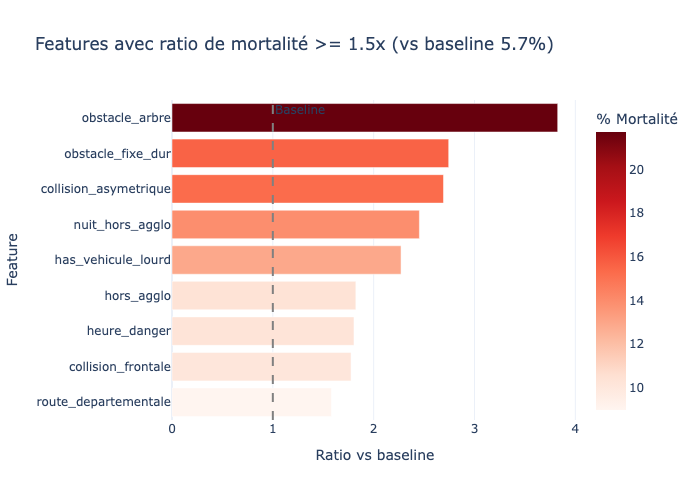

In [13]:
# top features par ratio de mortalité
df_mortality = pd.DataFrame(mortality_data)
df_mortality = df_mortality.sort_values('ratio', ascending=True)

# garder les features >= 1.5x baseline
df_top = df_mortality[df_mortality['ratio'] >= 1.5]

fig = px.bar(
    df_top,
    x='ratio',
    y='feature',
    orientation='h',
    color='mortel_rate',
    color_continuous_scale='Reds',
    title='Features avec ratio de mortalité >= 1.5x (vs baseline 5.7%)',
    labels={'ratio': 'Ratio vs baseline', 'feature': 'Feature', 'mortel_rate': '% Mortalité'}
)

fig.add_vline(x=1, line_dash="dash", line_color="gray", annotation_text="Baseline")
fig.update_layout(height=500, showlegend=False)
fig.show()

### Observation : Taux de mortalité par feature

Top 5 features les plus mortelles (ratio vs baseline 5.7%) :

| Feature | Mortalité | Ratio |
|---------|-----------|-------|
| obstacle_arbre | 21.7% | 3.8x |
| obstacle_fixe_dur | 15.6% | 2.7x |
| collision_asymetrique | 15.3% | 2.7x |
| nuit_hors_agglo | 13.9% | 2.5x |
| has_vehicule_lourd | 12.9% | 2.3x |

obstacle_arbre est 3.8x plus mortel que la moyenne, mais c'est une info post-accident → inutilisable en temps réel pour UC1.

---
## 9. Validation de la nouvelle feature heure_danger

---
VALIDATION heure_danger (2h-6h)
              mortel                grave       
               count    sum   mean    sum   mean
heure_danger                                    
0             193994  10345  0.053  67546  0.348
1              14622   1498  0.102   6250  0.427


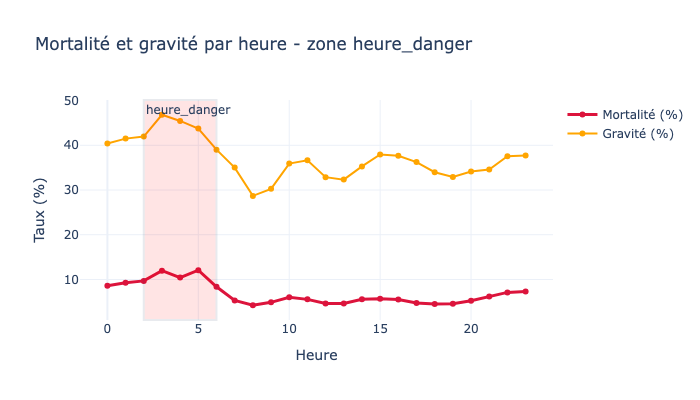

In [14]:
# validation de heure_danger (2h-6h)
print("---")
print("VALIDATION heure_danger (2h-6h)")

heure_danger_stats = df.groupby('heure_danger').agg({
    'mortel': ['count', 'sum', 'mean'],
    'grave': ['sum', 'mean']
}).round(3)

print(heure_danger_stats)

# taux par heure
hourly = df.groupby('heure').agg({
    'mortel': 'mean',
    'grave': 'mean'
}).reset_index()
hourly['mortel_pct'] = hourly['mortel'] * 100
hourly['grave_pct'] = hourly['grave'] * 100

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=hourly['heure'], y=hourly['mortel_pct'],
    mode='lines+markers', name='Mortalité (%)',
    line=dict(color='crimson', width=3)
))
fig.add_trace(go.Scatter(
    x=hourly['heure'], y=hourly['grave_pct'],
    mode='lines+markers', name='Gravité (%)',
    line=dict(color='orange', width=2)
))

# zone heure_danger
fig.add_vrect(x0=2, x1=6, fillcolor="red", opacity=0.1, 
              annotation_text="heure_danger", annotation_position="top left")

fig.update_layout(
    title="Mortalité et gravité par heure - zone heure_danger",
    xaxis_title="Heure",
    yaxis_title="Taux (%)",
    height=400
)
fig.show()

### Observation : Validation de heure_danger

Feature validée :
- Hors créneau 2h-6h : 5.3% mortalité (193,994 accidents)
- Dans créneau 2h-6h : 10.2% mortalité (14,622 accidents)
- Ratio : ~2x plus mortel dans le créneau danger

Le graphique confirme le pic de mortalité dans la zone 2h-6h.
→ Feature pertinente pour UC1 (heure disponible à l'appel).

---
## 10. Sélection des variables numériques à conserver

### Suppression des features redondantes (identifiées en 02b)

| Feature supprimée | Raison | Alternative |
|-------------------|--------|-------------|
| nb_conducteurs | Corr 0.998 avec nb_vehicules | Garder nb_vehicules |
| age_min | Corr 0.84 avec age_moyen | Garder age_moyen |
| age_max | Corr 0.87 avec age_moyen | Garder age_moyen |
| larrout | 75% valeurs manquantes | Exclure |

In [15]:
# variables numériques à conserver
num_vars_clean = [
    'dep', 'vma', 'nbv',
    'heure', 'mois',
    'age_moyen',
    'nb_usagers', 'nb_vehicules',
    'nb_pietons',
    'nb_hommes', 'nb_femmes',
]

meta_cols = ['Num_Acc', 'annee']
derived_features = ['weekend', 'heure_pointe', 'nuit']

print(f"Variables numériques conservées: {len(num_vars_clean)}")
print(f"Métadata: {meta_cols}")
print(f"Features dérivées (02a): {len(derived_features)}")
print(f"Features intelligentes: {len(new_features)}")

# vérification multicolinéarité
num_cols_present = [c for c in num_vars_clean if c in df.columns and df[c].dtype in ['int64', 'float64']]

if len(num_cols_present) > 1:
    corr_matrix = df[num_cols_present].corr()
    
    high_corr = []
    for i in range(len(num_cols_present)):
        for j in range(i+1, len(num_cols_present)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.7:
                high_corr.append((num_cols_present[i], num_cols_present[j], corr))
    
    if high_corr:
        print("\nCorrélations > 0.7 détectées:")
        for v1, v2, corr in high_corr:
            print(f"  {v1} <-> {v2}: {corr:.3f}")
    else:
        print("\nAucune corrélation > 0.7 entre les variables conservées.")

Variables numériques conservées: 11
Métadonnées: ['Num_Acc', 'annee']
Features dérivées (02a): 3
Features intelligentes: 28

Aucune corrélation > 0.7 entre les variables conservées.


### Observation : Variables numériques sélectionnées

11 variables numériques conservées (aucune corrélation > 0.7 entre elles) :
- Géographie : dep
- Route : vma, nbv
- Temporel : heure, mois
- Usagers : age_moyen, nb_usagers, nb_vehicules, nb_pietons, nb_hommes, nb_femmes

Suppressions appliquées : nb_conducteurs (corr 0.998), nb_passagers (corr 0.863), age_min/age_max (corr 0.84/0.87), larrout (75% manquant), jour_semaine (redondant avec weekend), lat/long (remplacés par dep).

---
## 11. Création du dataset final

In [16]:
# colonnes du dataset final
targets = ['mortel', 'grave']
final_cols = meta_cols + num_vars_clean + derived_features + new_features + targets

# vérifier que tout existe
missing = [col for col in final_cols if col not in df.columns]
if missing:
    print(f"ATTENTION: Colonnes manquantes: {missing}")
else:
    print("Toutes les colonnes sont présentes.")

df_final = df[final_cols].copy()

print(f"\nDataset final: {df_final.shape}")
print(f"  Métadata: {len(meta_cols)}")
print(f"  Numériques: {len(num_vars_clean)}")
print(f"  Dérivées: {len(derived_features)}")
print(f"  Intelligentes: {len(new_features)}")
print(f"  Targets: {len(targets)}")
print(f"  Total: {len(final_cols)} colonnes")

n_features = len(num_vars_clean) + len(derived_features) + len(new_features)
print(f"\nRéduction: 209 features encodées -> {n_features} features")

Toutes les colonnes sont présentes.

Dataset final: (208616, 46)
  Métadonnées: 2
  Numériques: 11
  Dérivées: 3
  Intelligentes: 28
  Targets: 2
  Total: 46 colonnes

Réduction: 209 features encodées -> 42 features


In [17]:
# sauvegarder
output_path = '../../data/dataset_features_intelligentes.csv'
df_final.to_csv(output_path, index=False)
print(f"Dataset sauvegardé: {output_path}")

print(f"\nAperçu:")
df_final.head()

Dataset sauvegardé: ../../data/dataset_features_intelligentes.csv

Aperçu:


,Num_Acc,annee,dep,vma,nbv,heure,mois,age_moyen,nb_usagers,nb_vehicules,...,has_edp,has_cyclomoteur,has_pieton,has_vehicule_lourd,collision_asymetrique,heure_danger,weekend_nuit,nuit_hors_agglo,mortel,grave
0,202100000001,2021,30,80.0,2.0,7,11,32.0,2,2,...,0,0,0,0,0,0,0,0,0,1
1,202100000002,2021,51,80.0,2.0,14,9,33.0,2,2,...,0,0,0,0,0,0,0,0,0,1
2,202100000003,2021,85,50.0,2.0,7,7,44.0,2,1,...,0,0,1,0,0,0,0,0,0,1
3,202100000004,2021,93,50.0,4.0,19,3,14.0,2,2,...,1,0,0,0,0,0,1,0,1,1
4,202100000005,2021,76,50.0,2.0,7,2,24.0,2,2,...,0,0,0,0,0,0,0,0,0,0


### Observation : Dataset final créé

Composition du dataset (208,616 × 46 colonnes) :
- 2 métadata (Num_Acc, annee)
- 11 variables numériques/catégorielles
- 3 features dérivées (02a : weekend, heure_pointe, nuit)
- 28 features intelligentes (nouvelles)
- 2 targets (mortel, grave)

Réduction : 42 features vs 209 en one-hot encoding (-80%)

---
## 12. Résumé des features créées

In [18]:
# résumé par catégorie
categories = {
    'Contexte': ['hors_agglo', 'nuit_eclairee', 'bidirectionnelle', 'haute_vitesse'],
    'Météo/Surface': ['meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente'],
    'Route': ['route_autoroute', 'route_departementale', 'route_communale'],
    'Collision': ['collision_frontale', 'collision_arriere', 'collision_cote', 'collision_solo'],
    'Obstacles': ['obstacle_arbre', 'obstacle_fixe_dur', 'obstacle_pieton'],
    'Véhicules': ['has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton',
                  'has_vehicule_lourd', 'collision_asymetrique'],
    'Temporelles': ['heure_danger', 'weekend_nuit', 'nuit_hors_agglo']
}

for cat, feats in categories.items():
    print(f"\n{cat} ({len(feats)}):")
    for f in feats:
        if f in df.columns:
            n = df[f].sum()
            pct = df[f].mean() * 100
            mortel_rate = df[df[f] == 1]['mortel'].mean() * 100 if df[f].sum() > 0 else 0
            print(f"  {f}: {n} ({pct:.1f}%) - {mortel_rate:.1f}% mortalité")

print("\n---")
print("Features supprimées:")
print("  nuit_non_eclairee, has_poids_lourd, has_bus, route_rapide, route_nationale")
print("  has_vulnerable (corr quasi-nulle)")
print("  lat, long -> remplacées par dep")


Contexte (4):
  hors_agglo: 76269 (36.6%) - 10.4% mortalité
  nuit_eclairee: 31601 (15.1%) - 3.3% mortalité
  bidirectionnelle: 127837 (61.3%) - 7.0% mortalité
  haute_vitesse: 29344 (14.1%) - 7.9% mortalité

Météo/Surface (4):
  meteo_degradee: 31096 (14.9%) - 5.7% mortalité
  surface_glissante: 41057 (19.7%) - 5.9% mortalité
  intersection_complexe: 67275 (32.2%) - 2.9% mortalité
  route_en_pente: 38910 (18.7%) - 8.0% mortalité

Route (3):
  route_autoroute: 20320 (9.7%) - 4.7% mortalité
  route_departementale: 79679 (38.2%) - 9.0% mortalité
  route_communale: 88185 (42.3%) - 2.8% mortalité

Collision (4):
  collision_frontale: 21985 (10.5%) - 10.1% mortalité
  collision_arriere: 27889 (13.4%) - 2.7% mortalité
  collision_cote: 63572 (30.5%) - 2.4% mortalité
  collision_solo: 20439 (9.8%) - 8.4% mortalité

Obstacles (3):
  obstacle_arbre: 5517 (2.6%) - 21.7% mortalité
  obstacle_fixe_dur: 15650 (7.5%) - 15.6% mortalité
  obstacle_pieton: 31542 (15.1%) - 5.3% mortalité

Véhicules (7)

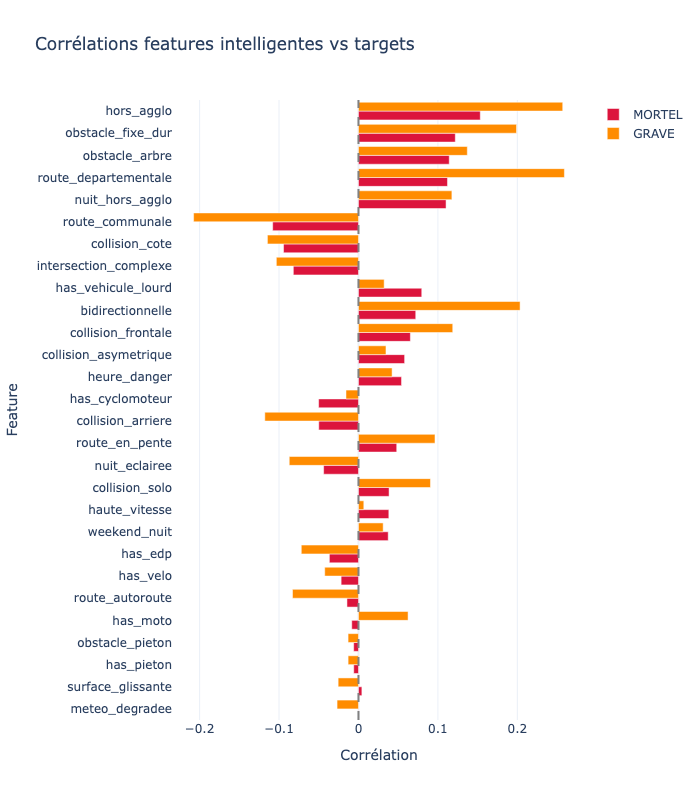

In [19]:
# heatmap corrélations features <-> targets
corr_with_targets = pd.DataFrame({
    'Feature': new_features,
    'MORTEL': [df[f].corr(df['mortel']) for f in new_features],
    'GRAVE': [df[f].corr(df['grave']) for f in new_features]
})

corr_with_targets['abs_mortel'] = corr_with_targets['MORTEL'].abs()
corr_with_targets = corr_with_targets.sort_values('abs_mortel', ascending=True)

fig = go.Figure()

fig.add_trace(go.Bar(
    y=corr_with_targets['Feature'],
    x=corr_with_targets['MORTEL'],
    name='MORTEL',
    orientation='h',
    marker_color='crimson'
))

fig.add_trace(go.Bar(
    y=corr_with_targets['Feature'],
    x=corr_with_targets['GRAVE'],
    name='GRAVE',
    orientation='h',
    marker_color='darkorange'
))

fig.update_layout(
    title='Corrélations features intelligentes vs targets',
    xaxis_title='Corrélation',
    yaxis_title='Feature',
    barmode='group',
    height=800
)

fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.show()

---
## Conclusions et décisions pour la suite

### 1. Dataset créé

| Aspect | Valeur |
|--------|--------|
| Fichier | dataset_features_intelligentes.csv |
| Accidents | 208,616 |
| Colonnes | 46 |
| Réduction | -80% vs one-hot encoding |

### 2. Features intelligentes créées (28 features)

| Catégorie | Features | Nombre |
|-----------|----------|--------|
| Contexte | hors_agglo, nuit_eclairee, bidirectionnelle, haute_vitesse | 4 |
| Météo/Surface (v2) | meteo_degradee, surface_glissante, intersection_complexe, route_en_pente | 4 |
| Route | route_autoroute, route_departementale, route_communale | 3 |
| Collision | collision_frontale, collision_arriere, collision_cote, collision_solo | 4 |
| Obstacles | obstacle_arbre, obstacle_fixe_dur, obstacle_pieton | 3 |
| Véhicules | has_moto, has_velo, has_edp, has_cyclomoteur, has_pieton, has_vehicule_lourd, collision_asymetrique | 7 |
| Temporelles | heure_danger, weekend_nuit, nuit_hors_agglo | 3 |

### 3. Features supprimées (multicolinéarité ou inutilité)

| Feature supprimée | Raison | Alternative |
|-------------------|--------|-------------|
| nb_conducteurs | Corr 0.998 avec nb_vehicules | Garder nb_vehicules |
| nb_passagers | Corr 0.863 avec nb_usagers | Garder nb_usagers |
| age_min | Corr 0.84 avec age_moyen | Garder age_moyen |
| age_max | Corr 0.87 avec age_moyen | Garder age_moyen |
| nuit_non_eclairee | Corr 0.875 avec nuit_hors_agglo | Garder nuit_hors_agglo |
| has_poids_lourd, has_bus | Inclus dans has_vehicule_lourd | Feature agrégée |
| route_nationale | Corr quasi-nulle avec target | Exclure |
| has_vulnerable | Corr -0.001 avec grave | Exclure |
| lat, long | Granularité inadaptée, overfitting | Utiliser dep |
| larrout | 75% valeurs manquantes | Exclure |

### 4. Top features par impact sur mortalité

| Feature | Taux mortalité | Ratio vs baseline (5.7%) |
|---------|----------------|--------------------------|
| obstacle_arbre | 21.7% | 3.8x |
| obstacle_fixe_dur | 15.6% | 2.7x |
| collision_asymetrique | 15.3% | 2.7x |
| nuit_hors_agglo | 13.9% | 2.5x |
| has_vehicule_lourd | 12.9% | 2.3x |
| heure_danger | 10.2% | 1.8x |

### 5. Points d'attention pour UC1 (temps réel)

Features à EXCLURE (post-accident, non disponibles à l'appel) :
- obstacle_arbre, obstacle_fixe_dur, obstacle_pieton

Features PRIORITAIRES (disponibles et prédictives) :
- hors_agglo, heure_danger, has_vehicule_lourd
- meteo_degradee, surface_glissante (conditions connues)
- collision_frontale (si décrit par l'appelant)

---
## Récapitulatif

### Features intelligentes créées (28)

| Catégorie | Nombre | Features |
|-----------|--------|----------|
| Contexte | 4 | hors_agglo, nuit_eclairee, bidirectionnelle, haute_vitesse |
| Météo/Surface | 4 | meteo_degradee, surface_glissante, intersection_complexe, route_en_pente |
| Route | 3 | route_autoroute, route_departementale, route_communale |
| Collision | 4 | collision_frontale, collision_arriere, collision_cote, collision_solo |
| Obstacles | 3 | obstacle_arbre, obstacle_fixe_dur, obstacle_pieton |
| Véhicules | 7 | has_moto, has_velo, has_edp, has_cyclomoteur, has_pieton, has_vehicule_lourd, collision_asymetrique |
| Temporelles/Interactions | 3 | heure_danger, weekend_nuit, nuit_hors_agglo |

### Autres variables conservées

| Catégorie | Nombre | Détail |
|-----------|--------|--------|
| Features dérivées (02a) | 3 | weekend, nuit, heure_pointe |
| Variables numériques | 11 | dep, vma, nbv, heure, mois, age_moyen, nb_usagers, nb_vehicules, nb_pietons, nb_hommes, nb_femmes |
| Supprimées | Variables | Multicolinéarité ou corrélation nulle avec cible |

**Prochaine étape** → `04a_dataset_UC1.ipynb` : création des 4 datasets progressifs pour le UC1.